# Project overview

* The goal of this project is to evaluate the feasibility of an automatic classification that would predict product categories upon images and/or text


* We will therefore implement Computer Vision and Natural Language Processing techniques


* Since the data is labeled we will consider it a supervised multi-label classification task

## Exploration

In [1]:
import pandas as pd

file_path = 'Data/flipkart_com-ecommerce_sample_1050_.csv'

data = pd.read_csv(file_path)

data.shape

(1050, 15)

There are 1050 products in the database.

In [2]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [3]:

### Parsing of the category-columns
def parsing_cat_cols(data):
    
    category_df = data['product_category_tree'].str.split(
    '>>', expand=True)


    category_df = category_df.apply(lambda x: x.str.replace('[', ""))
    category_df = category_df.apply(lambda x: x.str.replace(']', ""))
    category_df = category_df.apply(lambda x: x.str.replace(' ', ''))
    category_df = category_df.apply(lambda x: x.str.replace('"', ""))

    mapper = {0: 'category_0', 1: 'category_1', 2: 'category_2', 3: 'category_3',
              4: 'category_4', 5: 'category_5', 6: 'category_6'}

    category_df = category_df.rename(mapper, axis=1)

    data = pd.concat([data, category_df], axis=1)
    
    return data

In [4]:
data = parsing_cat_cols(data)

### Categories exploration

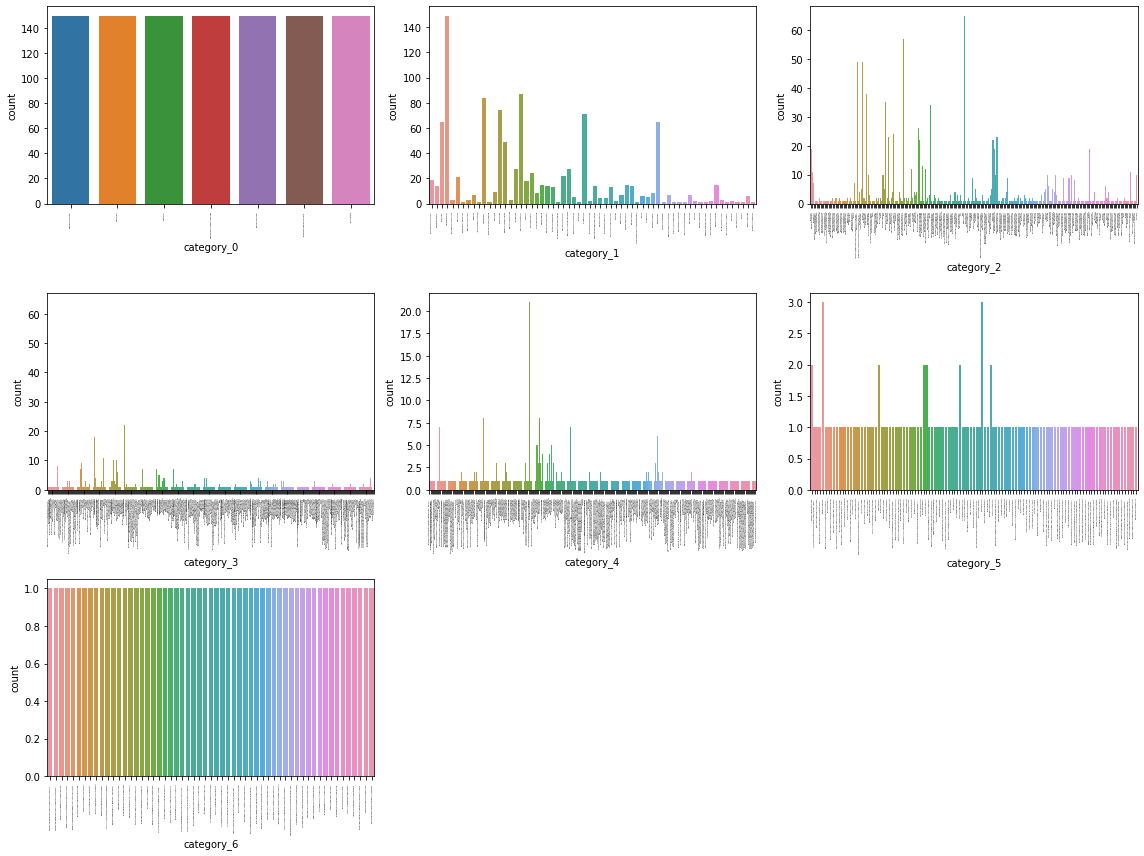

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def cat_distrib(data):

    cat_cols = ['category_' + str(i) for i in range(7)]
    
    fig = plt.figure(figsize=(16, 12))
    
    for i, col in enumerate(cat_cols):
        g = fig.add_subplot(3,3,i+1)
        g = sns.countplot(x = col, data = data)
        plt.xticks(fontsize = 2, rotation=90)
        
    fig.tight_layout()
        
        
cat_distrib(data)

* First category feature has 7 levels and samples are perfectly balanced accross labels


* Next levels of features have more labels, and with some of them represented by a very few number of samples


* We would need more data to train models on the deeper level of categories


* We will focus on the prediction of the categories feature with 7 levels

## Splits

### Train/test

* Train/test : 80/20

In [158]:
from sklearn.model_selection import train_test_split

### Split is stratified by category
X_train_, X_test, y_train_, y_test = train_test_split(data.drop('category_0', axis = 1), 
                                                data['category_0'], 
                                    stratify = data['category_0'], test_size = 0.2,
                                                random_state = 42)

### Train/validation

* We will create a validation dataset to control the estimators parameter before making predictions on the test set (train/validation : 80/20)

In [17]:
from sklearn.model_selection import train_test_split

### Split is stratified by category
X_train, X_valid, y_train, y_valid = train_test_split(X_train_, 
                                                y_train_, 
                                    stratify = y_train_, test_size = 0.2,
                                                random_state = 42)

## Computer vision

* We will implement two approaches:
    * Bag of Visual Words
    * Transfer leaning with CNNs

### Bag of Visual Words

The workflow for Bag of Words is as follows:
* preprocess images with an edge detector
* detect key-points on the images with SIFT
* define 'visual words' accross images by clustering on SIFT descriptors
* represent each image as a histogram with occurrences of each visual word

#### Read images

In [18]:
import cv2 as cv

def read_images(data):
    image_list = []
    for file_name in data['image']:
        image = cv.imread('Data/Images/' + file_name)
        image_list.append(image)
        
    return image_list

In [19]:
train_images, valid_images = read_images(X_train), read_images(X_valid)

Examples of images of each category

In [20]:
import numpy as np

### Displays one image per category for given subset of data
def examples_images(labels,images):
    
    images = images.copy()
    
    ### Converts list to array so a boolean indexer can be used to filter images
    images = np.array(images)
    
    
    fig = plt.figure(figsize = (16,9))
    for i, label in enumerate(labels.unique()):
        ax = fig.add_subplot(3,3,i+1)
        ### Filter to keep images of current category
        mask = (labels == label)
        filtered_images = images[mask]
        
        ax.imshow(filtered_images[0])
        ax.set_title(label + ' product example', fontsize = 12, pad = 16)
        
    fig.tight_layout()
    

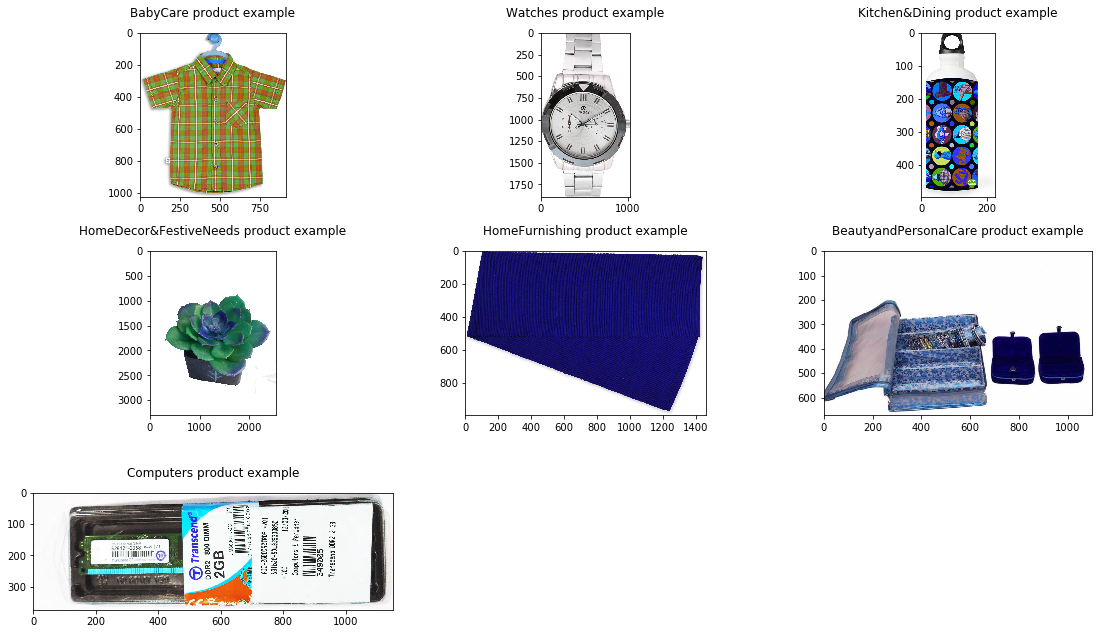

In [21]:
examples_images(y_train, train_images)

In [22]:
def images_per_category(labels, images, category):
    
    images = images.copy()
    
    ### Converts list to array so a boolean indexer can be used to filter images
    images = np.array(images)
    
    
    fig = plt.figure(figsize = (16,9))
        ### Filter to keep images of current category
    mask = (labels == category)
    filtered_images = images[mask]
    
    ### Displays first five images of the category
    for i, image in enumerate(filtered_images[:5]):
        ax = fig.add_subplot(3,3,i+1)
        ax.imshow(filtered_images[i])
        ax.set_title(category + ' product example', fontsize = 12, pad = 16)

    fig.tight_layout()
    

Examples of images of BabyCare category

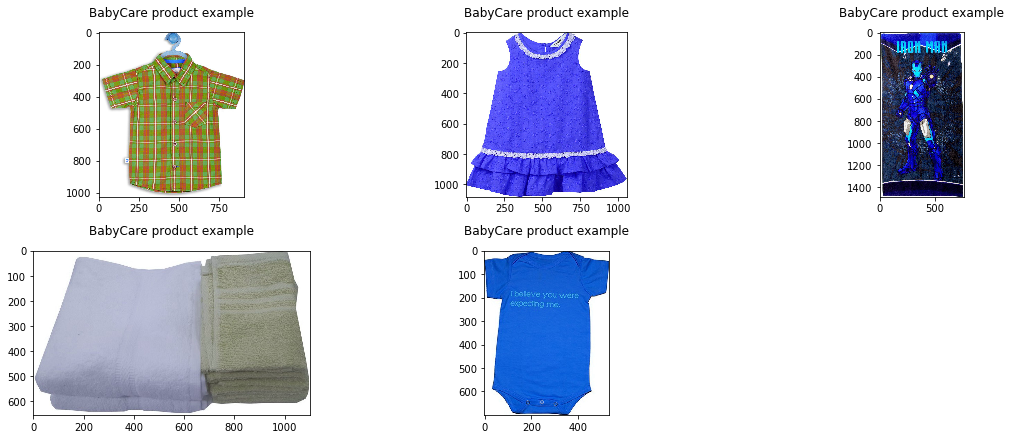

In [23]:
images_per_category(y_train, train_images, 'BabyCare')

#### Edge Detector 

* We will use Canny detector as Edge detector


* Edge detectors are useful for preprocessing the images before extracting features since they highlight the shapes of the objects


* The min and max threshold values to delete weak edges will be set to 100 and 200 


* Setting the maximum as the double of the minimum value is common practice

In [24]:
def edge_detector(images):
    
    images = images.copy()
    
    edged_images = [cv.Canny(img,100,200) for img in images]
    
    return edged_images

In [25]:
edged_train_images, edged_valid_images = edge_detector(train_images), edge_detector(valid_images)

Transformed images with Canny edge detector

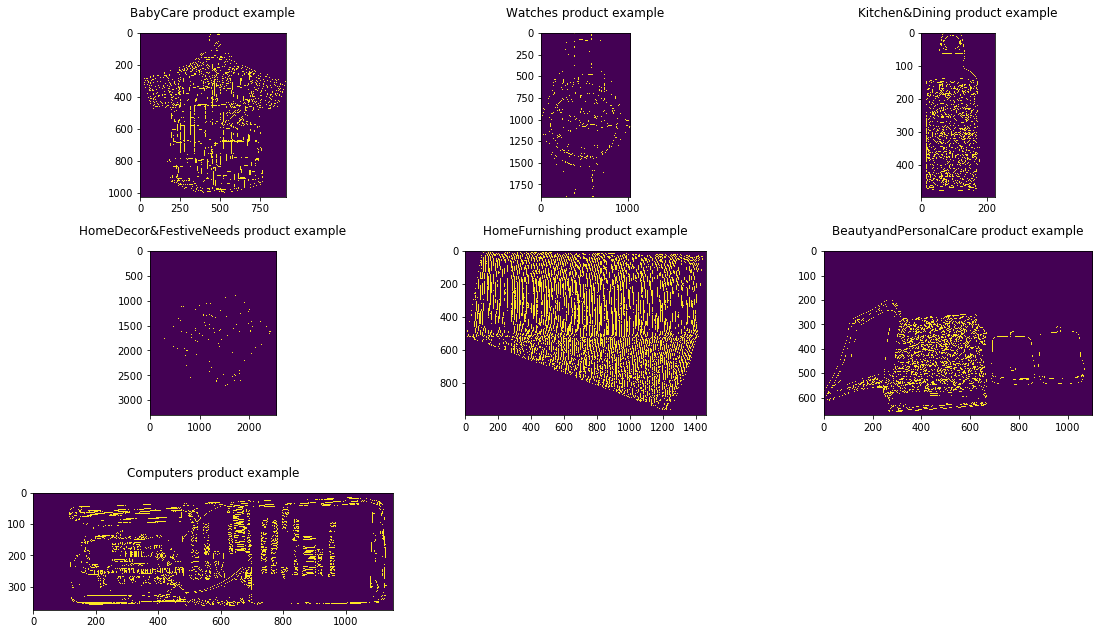

In [26]:
examples_images(y_train, edged_train_images)

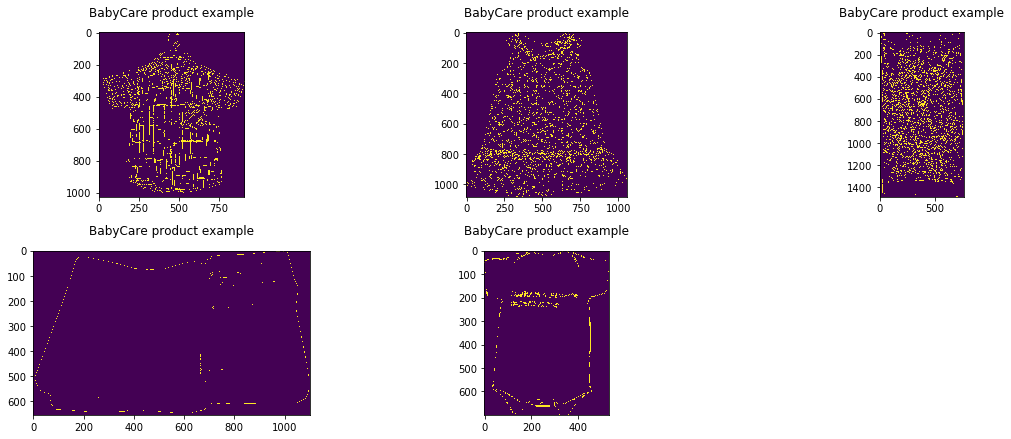

In [27]:
images_per_category(y_train, edged_train_images, 'BabyCare')

#### SIFT descriptors

* We will now extract feature from images with SIFT 


* SIFT detects key-points based on sharp changes of intensity in the image


* Each key-point is described by a 128-dim feature vectors

In [28]:
### Function that returns, for a given list of images, the number of SIFT descriptors for each image
def sift_number_of_descriptors_per_image(images):
    
    images = images.copy()

    # Initialiaze instance of SIFT detector/descriptor    
    sift = cv.SIFT_create()
    
    ### List containing all SIFT descriptors accross images
    descriptors = []
    
    ### List containing length of each feature matrix
    descriptors_length = []
    for i, image in enumerate(images):
        _, des = sift.detectAndCompute(image, None)
        
        if des is not None:
            descriptors_length.append(len(des))

    return descriptors_length

In [29]:
### Train_image at index 516 is causing memory troubles, too much SIFT descriptors seem to be found
train_images.pop(516)
edged_train_images.pop(516)
y_train.drop(y_train.index[516], inplace = True)
X_train.drop(X_train.index[516], inplace = True)

/home/marco/anaconda3/envs/tf_gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


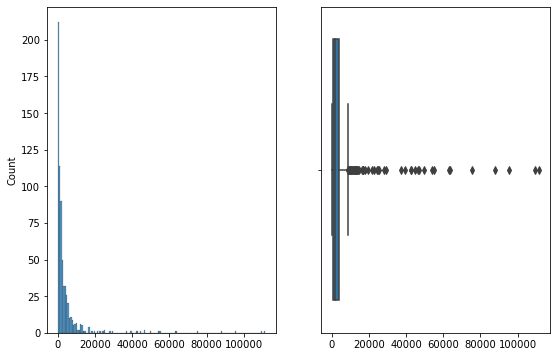

In [30]:
train_descriptors_length = sift_number_of_descriptors_per_image(edged_train_images)

### Visualizing number of descriptors per image distribution
fig = plt.figure(figsize = (9,6))
g = fig.add_subplot(1,2,1)
g = sns.histplot(train_descriptors_length)
g = fig.add_subplot(1,2,2)
g = sns.boxplot(train_descriptors_length)

In [31]:

### getting total number of descriptors of images with most descriptors for given percentiles 

###getting images' number of descriptors for the first 25% of images with most descriptors
mask_0_75 = np.array(train_descriptors_length) >= np.percentile(train_descriptors_length, 75)
images_with_most_descriptors_25 = np.array(train_descriptors_length)[mask_0_75]


mask_0_9 = np.array(train_descriptors_length) >= np.percentile(train_descriptors_length, 90)
images_with_most_descriptors_10 = np.array(train_descriptors_length)[mask_0_9]

mask_0_99 = np.array(train_descriptors_length) >= np.percentile(train_descriptors_length, 99) 
images_with_most_descriptors_1 = np.array(train_descriptors_length)[mask_0_99]


print('The 25% of images with most SIFT descriptors contain ' + "{:.0%}".format(sum(
images_with_most_descriptors_25)/sum(train_descriptors_length)) 
    + ' of the total number of descriptors accross images')


print('The 10% of images with most SIFT descriptors contain ' + "{:.0%}".format(sum(
images_with_most_descriptors_10)/sum(train_descriptors_length)) 
    + ' of the total number of descriptors accross images')


print('The 1% of images with most SIFT descriptors contain ' + "{:.0%}".format(sum(
images_with_most_descriptors_1)/sum(train_descriptors_length)) 
    + ' of the total number of descriptors accross images')


The 25% of images with most SIFT descriptors contain 78% of the total number of descriptors accross images
The 10% of images with most SIFT descriptors contain 60% of the total number of descriptors accross images
The 1% of images with most SIFT descriptors contain 21% of the total number of descriptors accross images


* Only 1% of the images contain more than 20% of the descriptors accross images
* 10% of the images almost 60%

* The risk working with such a distribution is to overfit the visual words of the corpus to a small subset of the data 

* We will figure this out by setting a maximum value for the number of key-points described in each image

In [32]:
pd.Series(train_descriptors_length).describe(percentiles = [.25, .5, .75, .9, .95, .99])

count       671.000000
mean       4357.025335
std       10841.612688
min           7.000000
25%         557.000000
50%        1563.000000
75%        3844.500000
90%        8034.000000
95%       13390.000000
99%       57433.000000
max      111564.000000
dtype: float64

* We can see there is a gap between 95th and 99th percentile
* Less than 10% of images have a number of key-points superior to ~8000
* 10 000 could be a reasonable limit for the number of key-points detected for each image

In [33]:
### Function that returns, for a given list of images, the number of SIFT descriptors for each image
def sift_number_of_descriptors_per_image_with_maximum(images, threshold):
    
    images = images.copy()

    # Initialiaze instance of SIFT detector/descriptor    
    sift = cv.SIFT_create(nfeatures = threshold)
    
    ### List containing all SIFT descriptors accross images
    descriptors = []
    
    ### List containing length of each feature matrix
    descriptors_length = []
    for i, image in enumerate(images):
        des = sift.detectAndCompute(image, None)[1]
        
        if des is not None:
            descriptors_length.append(len(des))

    return descriptors_length

/home/marco/anaconda3/envs/tf_gpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


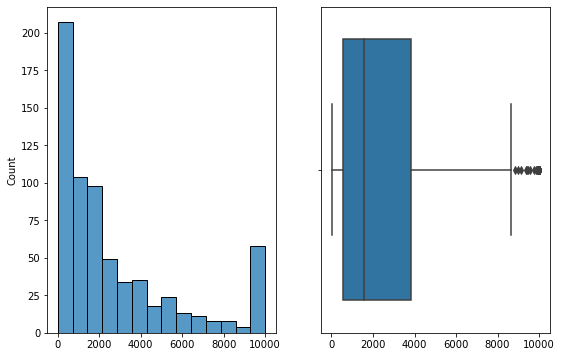

In [34]:
train_descriptors_length = sift_number_of_descriptors_per_image_with_maximum(edged_train_images, 10000)

### Visualizing number of descriptors per image distribution
fig = plt.figure(figsize = (9,6))
g = fig.add_subplot(1,2,1)
g = sns.histplot(train_descriptors_length)
g = fig.add_subplot(1,2,2)
g = sns.boxplot(train_descriptors_length)

In [35]:

### getting total number of descriptors of images above 0.75, 0.9 and 0.99 percentiles
mask_0_75 = np.array(train_descriptors_length) >= np.percentile(train_descriptors_length, 75)
images_with_most_descriptors_25 = np.array(train_descriptors_length)[mask_0_75]


mask_0_9 = np.array(train_descriptors_length) >= np.percentile(train_descriptors_length, 90)
images_with_most_descriptors_10 = np.array(train_descriptors_length)[mask_0_9]

mask_0_99 = np.array(train_descriptors_length) >= np.percentile(train_descriptors_length, 99) 
images_with_most_descriptors_1 = np.array(train_descriptors_length)[mask_0_99]


print('The 25% of images with most SIFT descriptors contain ' + "{:.0%}".format(sum(
images_with_most_descriptors_25)/sum(train_descriptors_length)) 
    + ' of the total number of descriptors accross images')


print('The 10% of images with most SIFT descriptors contain ' + "{:.0%}".format(sum(
images_with_most_descriptors_10)/sum(train_descriptors_length)) 
    + ' of the total number of descriptors accross images')


print('The 1% of images with most SIFT descriptors contain ' + "{:.0%}".format(sum(
images_with_most_descriptors_1)/sum(train_descriptors_length)) 
    + ' of the total number of descriptors accross images')


The 25% of images with most SIFT descriptors contain 66% of the total number of descriptors accross images
The 10% of images with most SIFT descriptors contain 36% of the total number of descriptors accross images
The 1% of images with most SIFT descriptors contain 10% of the total number of descriptors accross images


* The ratios are a lot more reasonable now after setting a maximal number of key-points for each image
* Let's extract the descriptors of each image with the new setting

In [36]:
### Function that returns, for a given list of images
### 1. a list of 2D-arrays where each array contains all SIFT descriptors for a given image
### 2. a 2-D array that contains all descriptors accross images

def sift_descriptor(images):
    
    images = images.copy()

    # Initialiaze instance of SIFT detector/descriptor    
    sift = cv.SIFT_create(nfeatures = 10000)
    
    ### List containing all SIFT descriptors accross images
    descriptors = []
    
    ### List containing length of each feature matrix
    for i, image in enumerate(images):
        _ , des = sift.detectAndCompute(image, None)
        
        if des is not None:
            descriptors.append(des)
            
    return descriptors

In [37]:
### Extracting descriptors 
train_descriptors, valid_descriptors = sift_descriptor(edged_train_images), sift_descriptor(edged_valid_images)

#### PCA on SIFT descriptors

* SIFT descriptors have 128-dim which is quite high


* Next step is to define visual words on the corpus by clustering on the descriptors matrix


* Before clustering we may want to delete the noise and redundancies the descriptors may contain so the fitted visual words are more robust and trained in less time


* We will use PCA to reduce feature vectors dimensions and search to reach an optimal trade-off between explained variance and dimension reduction

In [38]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

### Function that displays number of components needed for given explained variance ratios
def dim_reduction(descriptors): 
    
    descriptors = descriptors.copy()
    
    ### 
    descriptors_matrix = []
    for image_descriptors in descriptors:
        descriptors_matrix.extend(image_descriptors)
        
    ### Transforms list of descriptors to 2-D array
    descriptors_matrix  = np.array(descriptors_matrix)


    n_components = []
    ### Get minimum number of components needed for given explained variance ratio
    for i, variance in enumerate([0.5, 0.6, 0.7, 0.8, 0.9, 0.95]):
        pca = PCA(n_components = variance)
        pca.fit(descriptors_matrix)
        print('Fitting PCA ' + str(i+1))
        n_components.append(pca.n_components_)
    
    
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    ax.plot(n_components, color='red', linestyle='dashed', marker='o',
            markerfacecolor='blue', markersize=10)
    ax.set_xticks(np.arange(0, 6, 1))
    ax.set_xticklabels([0.5, 0.6, 0.7, 0.8, 0.9, 0.95], fontsize=10)
    ax.set_title('Dimension reduction', fontsize=16)
    ax.set_ylabel('N components', fontsize=12)
    ax.set_xlabel('Explained variance', fontsize=12)

Fitting PCA 1
Fitting PCA 2
Fitting PCA 3
Fitting PCA 4
Fitting PCA 5
Fitting PCA 6


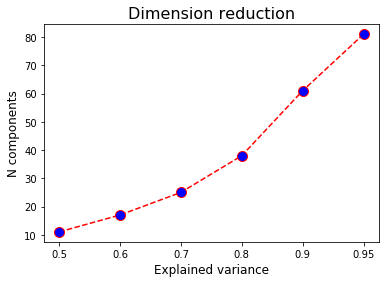

In [39]:
dim_reduction(train_descriptors)

* ~40 components for 80% of explained variance seem optimal here

In [40]:
import time

### Reduces the descriptors array with PCA
### Returns:
### 1. The reduced descriptors array with optimal number of components
### 2 .The reduced descriptors arrays for each image

def fitting_pca(descriptors, optimal_variance):
    
    descriptors = descriptors.copy()
    
    descriptors_matrix = []
    
    for image_descriptors in descriptors:
        descriptors_matrix.extend(image_descriptors)
        
    descriptors_matrix = np.array(descriptors_matrix)
    
    pca = PCA(n_components = optimal_variance)
    pca.fit(descriptors_matrix)
    
    return pca

In [41]:
pca = fitting_pca(train_descriptors, 0.8)

In [42]:
def pca_reduction(descriptors, model):

    descriptors = descriptors.copy()
    
    reduced_descriptors = [model.transform(image_descriptors) for image_descriptors in descriptors]
    
    
    return reduced_descriptors

In [43]:
reduced_train_descriptors, reduced_valid_descriptors = pca_reduction(train_descriptors, pca), pca_reduction(valid_descriptors, pca)

#### Visual words &  histograms

* we will now fit a KMeans clustering model
* each centroid of the fitted model will represent a Visual Word of the corpus
* each image will be represented as a histogram where each value is equal to the frequency of corresponding visual word in the image  

In [44]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import time

def fitting_visual_words(descriptors):
    
    
    descriptors = descriptors.copy()
    
    descriptors_matrix = []
    
    for image_descriptors in descriptors:
        descriptors_matrix.extend(image_descriptors)
        
    descriptors_matrix = np.array(descriptors_matrix)

    # Kmeans
    kmeans = MiniBatchKMeans(n_clusters=int(
        np.sqrt(len(descriptors_matrix))),
                        batch_size = int(0.05*len(descriptors_matrix)),
            random_state=42)
    
    # Fit the model to determine its centers positions
    t0 = time.time()
    kmeans.fit(descriptors_matrix)
    
    t1 = time.time() - t0
    
    print('Visual words fitting time is ' + str(t1))
    
    return kmeans

In [45]:
visual_words_model = fitting_visual_words(reduced_train_descriptors)

Visual words fitting time is 510.0962052345276


In [46]:
def building_histograms(descriptors, model):
    
    histograms = []
    
    for image_descriptors in descriptors:
        labels = model.predict(image_descriptors)
        
        ### Histogram with each visual word occurrence
        histogram = np.zeros(len(model.cluster_centers_))
        
        for label in labels:
            histogram[label] += 1
        
        ### Normalizing by frequency
        histogram = histogram/len(image_descriptors)
        histograms.append(histogram)
        
    histograms = np.array(histograms)
        
    
    return histograms
    

In [47]:
train_histograms, valid_histograms = building_histograms(reduced_train_descriptors, visual_words_model), building_histograms(reduced_valid_descriptors, visual_words_model) 

### Estimators

* We will train widely used classifiers 
    * knn
    * Support Vector Machines
    * Random Forest
    * Neural network classification layer
    * Dummy classifier for the baseline
    
    
* Since the **categories** are **uniformly** distributed and there is no **priority in better predicting** a subset of categories, the **estimators** will be evaluated on **accuracy score**

#### Neural Network

In [77]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score
import numpy as np


gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


def neural_network_classification(X_train, X_valid, y_train, y_valid):

    ### 7-classes to predict
    ### softmax activation allows to interpret output vectors as conditional probabilities

    
    enc = LabelEncoder()
    
    ### Converting target labels to integers to be able to convert into tensors
    enc_y_train = enc.fit_transform(y_train)
    enc_y_valid = enc.transform(y_valid)

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, enc_y_train))
    validation_dataset = tf.data.Dataset.from_tensor_slices((X_valid, enc_y_valid))

    ### Batching and prefetching

    batch_size = 32
    train_dataset = train_dataset.batch(batch_size).prefetch(1)
    validation_dataset = validation_dataset.batch(batch_size).prefetch(1)



    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    outputs = tf.keras.layers.Dense(7, activation='softmax')(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    optimizer = keras.optimizers.SGD(lr = 0.2, momentum = 0.9, decay = 0.01)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer,
            metrics = ['accuracy']) 


    history = model.fit(train_dataset, epochs = 5, validation_data = validation_dataset)

    
    ### get class probabilities
    neural_preds = model.predict(X_valid)
    
    ### get predicted classes
    neural_preds = neural_preds.argmax(axis=-1)
    
    ### Perform encoder's inverse transformation
    neural_preds = enc.inverse_transform(neural_preds)
    
    
    return neural_preds

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

def get_estimators_scores(X_train, X_test, y_train, y_test):
    
    neural_preds = neural_network_classification(X_train, X_test, y_train, y_test)
    
    ### compute accuracy score
    neural_network_accuracy = accuracy_score(y_test, neural_preds)
    
    ### Random Forest
    rf = RandomForestClassifier(random_state = 42)
    
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    
    ### Support Vector Machines
    svc = SVC(random_state = 42)
    
    svc.fit(X_train, y_train)
    svc_pred = svc.predict(X_test)

    svc_accuracy = accuracy_score(y_test, svc_pred)
    

    ### k-nearest neighbors
    
    knn = KNeighborsClassifier()   
    
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_test)
    knn_accuracy = accuracy_score(y_test, knn_pred)

    
    ### Dummy
    
    dummy = DummyClassifier(strategy = 'most_frequent', random_state = 42)
    
    dummy.fit(X_train, y_train)
    dummy_pred = dummy.predict(X_test)

    dummy_accuracy = accuracy_score(y_test, dummy_pred)

    
    return neural_network_accuracy, rf_accuracy, svc_accuracy, knn_accuracy, dummy_accuracy

In [79]:
neural_network_accuracy, rf_accuracy, svc_accuracy, knn_accuracy, dummy_accuracy = get_estimators_scores(train_histograms, valid_histograms, y_train, y_valid)

Epoch 1/5
21/21 [==============================] - 0s 4ms/step - loss: 1.9639 - accuracy: 0.1267 - val_loss: 1.9541 - val_accuracy: 0.1429
Epoch 2/5
21/21 [==============================] - 0s 2ms/step - loss: 1.9645 - accuracy: 0.1088 - val_loss: 1.9454 - val_accuracy: 0.1429
Epoch 3/5
21/21 [==============================] - 0s 2ms/step - loss: 1.9568 - accuracy: 0.1043 - val_loss: 1.9449 - val_accuracy: 0.1429
Epoch 4/5
21/21 [==============================] - 0s 2ms/step - loss: 1.9540 - accuracy: 0.1192 - val_loss: 1.9431 - val_accuracy: 0.1488
Epoch 5/5
21/21 [==============================] - 0s 2ms/step - loss: 1.9514 - accuracy: 0.1282 - val_loss: 1.9420 - val_accuracy: 0.1488


### Ranking

In [80]:
def ranking(scores):
    
    ### estimator label
    estimators = [estimator for estimator, _ in scores]
    
    ### estimator score
    scores = [score for _, score in scores]
    
    fig = plt.figure(figsize = (9,6))

    ax = fig.add_subplot(111)

    palette = sns.light_palette("navy", n_colors = 5)

    ax.bar(x = np.arange(0,5,1), height = 
        np.sort(scores), 
        color = palette)
    ax.set_title('Estimators performance', fontsize = 14, pad = 16)
    ax.set_xticks(np.arange(0,5,1))

    ### Sorting labels
    sorted_labels, _ = zip(*sorted(zip(estimators,
                                       scores), 
                            key = lambda k : k[1]))
    ax.set_xticklabels(sorted_labels, fontsize = 10)
    ax.set_ylabel('Accuracy', fontsize = 12)

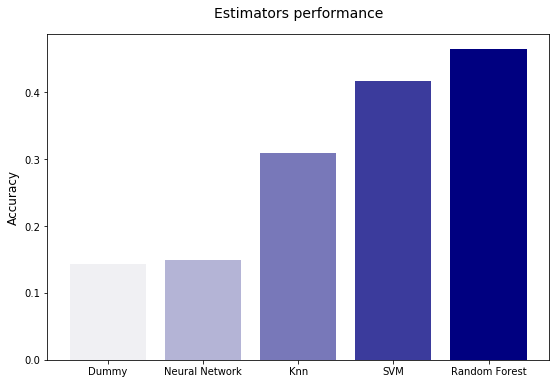

In [81]:
ranking([('Neural Network', neural_network_accuracy), 
        ('Random Forest', rf_accuracy), 
        ('SVM', svc_accuracy), 
        ('Knn', knn_accuracy), 
        ('Dummy', dummy_accuracy)])

* **Random Forest** is the most performing estimator with an **accuracy ~ 0.45**


* Performance is **not optimal** but still significantly superior to a **dummy classification**


* The **BOVW** approach allows to extract some features that are relevant for estimators


* Further research could try top optimize each transformation step of the process and also optimize estimators' settings


* However **more recent techniques** may produce better performance on predicting the **categories**

### Confusion Matrix

In [82]:
from sklearn.metrics import confusion_matrix

def conf_matrix(y_true, y_pred):
    
    matrix = confusion_matrix(y_true, y_pred)
    
    fig = plt.figure(figsize = (9,6))
    g = fig.add_subplot(111)
    
    palette = sns.light_palette("navy")
    g = sns.heatmap(matrix, annot = True, fmt='2g', 
    annot_kws={"size": 10}, cmap = palette)
    
    g.set_yticks(g.get_yticks())
    g.set_yticklabels(['BabyCare', 'BeautyandPersonalCare', 'Computers', 
    'HomeDecor&FestiveNeeds', 
 'HomeFurnishing', 'Kitchen&Dining', 'Watches'], rotation = 0)
    g.set_xticks(g.get_xticks())
    g.set_xticklabels(['BabyCare', 'BeautyandPersonalCare', 'Computers',
    'HomeDecor&FestiveNeeds', 'HomeFurnishing', 'Kitchen&Dining', 'Watches'], rotation = 90)
    g.set_ylabel('Actual', fontsize = 14)
    g.set_xlabel('Predicted', fontsize = 14)

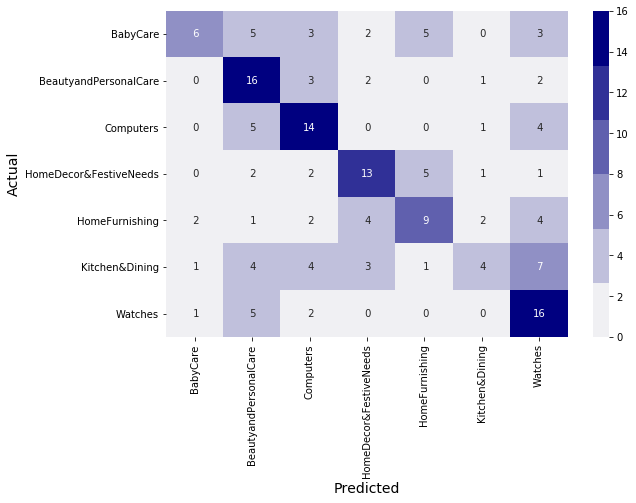

In [84]:
### random forest is the best estimator
rf = RandomForestClassifier(random_state = 42)
rf.fit(train_histograms,y_train)

rf_pred = rf.predict(valid_histograms)

conf_matrix(y_valid, rf_pred)

### Examples of mislabeled images

In [85]:
def mislabeled_images(actual, predicted):
    
    mask = (y_valid == actual) & (rf_pred == predicted)
    
    mislabeled_images = np.array(valid_images)[mask]
    
    fig = plt.figure(figsize = (9,6))
    for i, image in enumerate(mislabeled_images[:5]):
        ax = fig.add_subplot(2,3,i+1)
        ax.imshow(image)
    


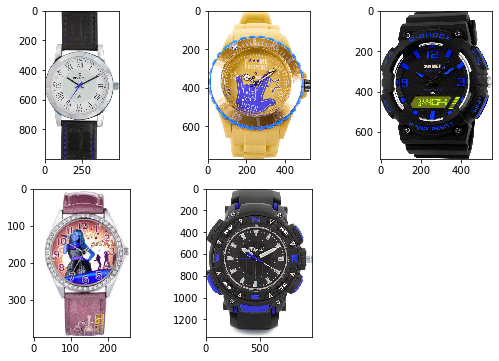

In [86]:
mislabeled_images(actual = 'Watches', predicted = 'BeautyandPersonalCare')

* These samples were **predicted** as belonging to the **Beauty&Personalcare** category instead of **watches** 

### 2-D visualizations

#### Histograms dimension reduction: kmeans

* We will represent the histograms in a 2-D space to get insights on whether the features extraction method allows to clearly separate the categories and thus facilitates estimators's fitting

* we will used three dimension reduction algorithms:
    * TSNE
    * PCA
    * UMAP
    
* Given the high dimensionality of the feature space (~1400 visual words), and knowing that for example TSNE operates better on lower dimensions, we will make a first dimension reduction step with KMeans

In [87]:
def kmeans_dimension_reduction(data, n_clusters): #takes histogram as input and reduces its dimension
    
    data = data.copy()
    
    kmeans = KMeans(n_clusters = n_clusters, random_state = 42)
    
    # Reduce the feature space dimension to the number of clusters
    data = kmeans.fit_transform(data)
    
    return data

In [88]:
reduced_2d_train_histograms = kmeans_dimension_reduction(train_histograms, 50)

In [89]:
# Function that defines scatterplot for 2D cluster visualization 
def scatter(embedded_data, labels, transformer):
    
    embedded_data = embedded_data.copy()
    
    fig = plt.figure(figsize = (9,6))
    g = fig.add_subplot(111)
    
    matrix = np.column_stack([embedded_data, labels])
    data = pd.DataFrame(matrix, columns = ['dim_1', 'dim_2', 'labels'])
    
    g = sns.scatterplot(x = 'dim_1', y = 'dim_2', hue = 'labels', data = data)
    g.set_title('2D visualization with ' + transformer, fontsize = 16, pad = 16)


#### TSNE 

In [90]:
from sklearn.manifold import TSNE
import seaborn as sns

# takes array as input, reduces its dimensions with TSNE, and plots points in 2D space 
#aside with clustering predictions and actual categories

def tsne_reduction(data, n_components, labels):

    data = data.copy()
    
    # Reduce dimension of feature space
    tsne = TSNE(n_components= n_components, 
                random_state = 42)
    embedded_data = tsne.fit_transform(data)
    
    #calls plot function
    
    scatter(embedded_data, labels, 'TSNE')
    

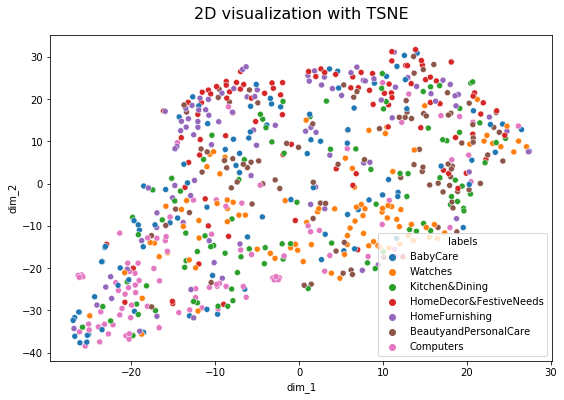

In [91]:
tsne_reduction(reduced_2d_train_histograms, 2, y_train)

#### PCA

In [92]:
def pca_reduction(data, n_components, labels):

        data = data.copy()

        # Reduce dimension of feature space
        pca = PCA(n_components= n_components)
        embedded_data = pca.fit_transform(data)
    
        
        scatter(embedded_data, labels, 'PCA')

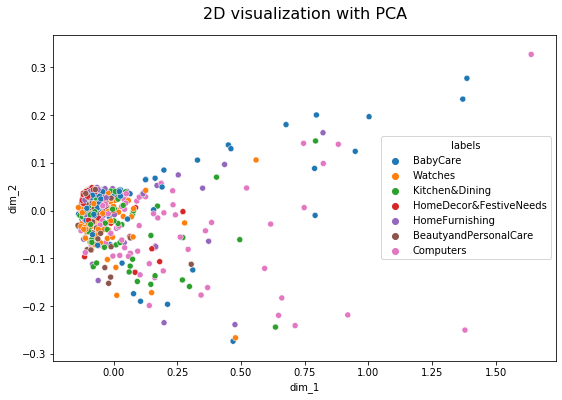

In [93]:
pca_reduction(reduced_2d_train_histograms, 2, y_train)

#### UMAP 

In [94]:
import umap.umap_ as umap

def umap_reduction(data, n_components, labels):
    
    data = data.copy()
    
    # Reduce dimension of feature space
    umap_model = umap.UMAP(n_neighbors = 15, min_dist = 0, n_components = 2, verbose = True, 
                    random_state = 42)
    embedded_data = umap_model.fit_transform(data)
    
    scatter(embedded_data, labels, 'UMAP')

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0, random_state=42, verbose=True)
Construct fuzzy simplicial set
Mon Jan 18 22:59:59 2021 Finding Nearest Neighbors
Mon Jan 18 23:00:01 2021 Finished Nearest Neighbor Search
Mon Jan 18 23:00:02 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jan 18 23:00:04 2021 Finished embedding


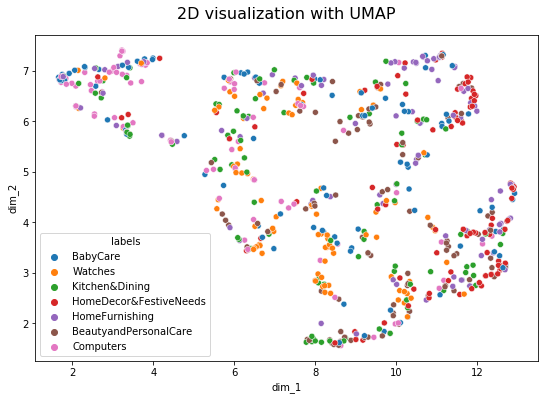

In [95]:
umap_reduction(reduced_2d_train_histograms, 2, y_train)

* The **visualizations** produced by the three dimension reduction techniques (**TSNE, PCA & UMAP**) show that it is difficult to clearly **separate the categories** in the histogram-based feature space 

* We will now try a more recent approach : **transfer leaning** with **Convolutional Neural Networks**

### Transfer learning : CNN

* We will **extract features** by implementing a **CNN pre-trained model** that is widely known as being one of the **most performing** : **Resnet-50**, a model implementing a **ResNet** architecture


* We will keep the **trained weights** on the **ImageNet** dataset to extract the features


* In the next step we will **train** various **classifiers** on the **extracted features**

#### Extracting features : Resnet-50

In [96]:

def extracting_features(train_images, valid_images, y_train, y_valid):
    
    
    ### resizing images so that they fit as Tensor input for the first layer of the CNN 
    train_images = [cv.resize(img, (224,224)) for img in train_images]
    valid_images = [cv.resize(img, (224,224)) for img in valid_images]
    
    
    ### instantiating pre-trained Resnet-50 CNN model
    base_model = keras.applications.resnet50.ResNet50(weights='imagenet',
                                                      include_top=False)
    ### flatten the output arrays
    flatten_output = keras.layers.Flatten()(base_model.output)
    
    ### building the model
    model = keras.Model(inputs = base_model.input, outputs = flatten_output)

    
    train_images = tf.convert_to_tensor(train_images)
    valid_images = tf.convert_to_tensor(valid_images)
    
    ### extracting features with the model
    train_features = model.predict(train_images)
    valid_features = model.predict(valid_images)
    
    
    return train_features, valid_features



In [97]:
train_features, valid_features = extracting_features(train_images, valid_images, y_train, y_valid)

#### Dimension reduction : PCA

* The **dimensionality** of the features matrix is ~ **100 000**, which is very **high**


* This can lead to **higher fitting times** when **training** the estimators


* Thus we will perform a **dimension reduction** with **PCA**

In [98]:
def reducing_features_dim(features):
        
    features = features.copy()
    
    
    n_components = []
    
    ### Get minimum number of components needed for given explained variance ratio
    for i, variance in enumerate([0.5, 0.6, 0.7, 0.8, 0.9, 0.95]):
        pca = PCA(n_components = variance)
        print('Fitting PCA ' + str(i+1))
        pca.fit(features)
        n_components.append(pca.n_components_)
    
    
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    ax.plot(n_components, color='red', linestyle='dashed', marker='o',
            markerfacecolor='blue', markersize=10)
    ax.set_xticks(np.arange(0, 6, 1))
    ax.set_xticklabels([0.5, 0.6, 0.7, 0.8, 0.9, 0.95], fontsize=10)
    ax.set_title('Dimension reduction', fontsize=16)
    ax.set_ylabel('N components', fontsize=12)
    ax.set_xlabel('Explained variance', fontsize=12)


Fitting PCA 1
Fitting PCA 2
Fitting PCA 3
Fitting PCA 4
Fitting PCA 5
Fitting PCA 6


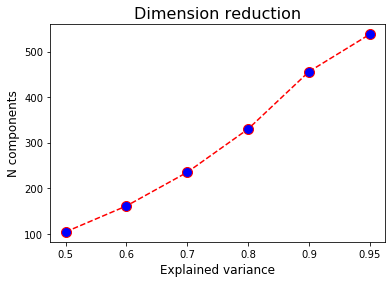

In [99]:
reducing_features_dim(train_features)

* We can get a huge **benefit** by reducing dimension


* We can keep only ~ **500** features vs  ~ **100 000** and still explain **95%** of variance among samples  

In [100]:
def pca_model(features, optimal_variance):
    
    features = features.copy()
    
    pca = PCA(n_components = optimal_variance)
    pca.fit(features)
    
    return pca

In [101]:
pca = pca_model(train_features, 0.95)

In [102]:
def get_reduced_features(features, model):

    features = features.copy()
    
    reduced_features = model.transform(features)
    
    return reduced_features

In [103]:
reduced_train_features, reduced_valid_features = get_reduced_features(train_features, pca), get_reduced_features(valid_features, pca)

### Estimators

* As for the previous approach we will try widely used classifiers
    * knn
    * Support Vector Machines
    * Random Forest
    * Neural network classification layer
    * Dummy classifier for the baseline
    


* The goal is to reach the **best possible model**, ie the best **features** & the best **estimator**


* Also we will be able to **compare** directly the two **feature extraction** techniques, having trained the **same estimators** on features extracted by each approach

In [104]:
neural_network_accuracy, rf_accuracy, svc_accuracy, knn_accuracy, dummy_accuracy = get_estimators_scores(reduced_train_features, reduced_valid_features, y_train, y_valid)

Epoch 1/5
21/21 [==============================] - 0s 5ms/step - loss: 446.0846 - accuracy: 0.7019 - val_loss: 748.2837 - val_accuracy: 0.7738
Epoch 2/5
21/21 [==============================] - 0s 2ms/step - loss: 218.8467 - accuracy: 0.9121 - val_loss: 798.5104 - val_accuracy: 0.8036
Epoch 3/5
21/21 [==============================] - 0s 2ms/step - loss: 32.5104 - accuracy: 0.9776 - val_loss: 929.9022 - val_accuracy: 0.8095
Epoch 4/5
21/21 [==============================] - 0s 2ms/step - loss: 2.5088 - accuracy: 0.9940 - val_loss: 937.9008 - val_accuracy: 0.8095
Epoch 5/5
21/21 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 939.4341 - val_accuracy: 0.8095


### Ranking

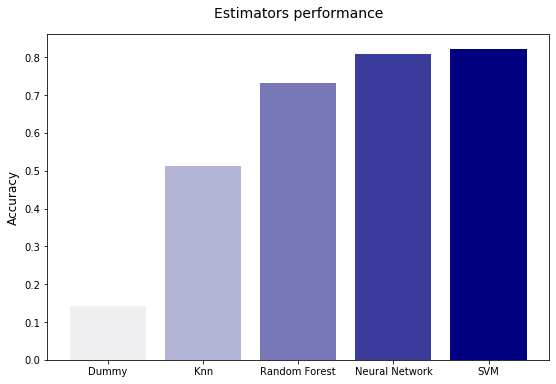

In [105]:
ranking([('Neural Network', neural_network_accuracy), 
        ('Random Forest', rf_accuracy), 
        ('SVM', svc_accuracy), 
        ('Knn', knn_accuracy), 
        ('Dummy', dummy_accuracy)])

* The **overall performance** of all the estimators is significantly **superior** when trained on the **Resnet-extracted features** than on the **BOVW**-extracted ones


* The best **estimators** achieve a performance ~ **0.8** on accuracy 


* The best estimator is the **Neural Network** classifier layer, which performs much better on these features


* The **transfer leaning** approach is very relevant and enables building a **robust** product **classifier**

### Confusion matrix

Epoch 1/5
21/21 [==============================] - 0s 5ms/step - loss: 456.7509 - accuracy: 0.6841 - val_loss: 804.4617 - val_accuracy: 0.8036
Epoch 2/5
21/21 [==============================] - 0s 2ms/step - loss: 225.5345 - accuracy: 0.9300 - val_loss: 894.3896 - val_accuracy: 0.8214
Epoch 3/5
21/21 [==============================] - 0s 2ms/step - loss: 21.6149 - accuracy: 0.9866 - val_loss: 995.4205 - val_accuracy: 0.8155
Epoch 4/5
21/21 [==============================] - 0s 2ms/step - loss: 6.1117 - accuracy: 0.9940 - val_loss: 1023.8304 - val_accuracy: 0.8155
Epoch 5/5
21/21 [==============================] - 0s 2ms/step - loss: 0.2707 - accuracy: 0.9970 - val_loss: 1025.4135 - val_accuracy: 0.8155


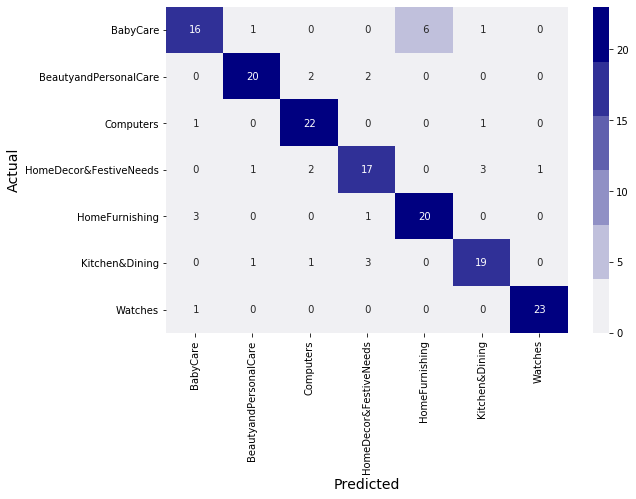

In [106]:

svc = SVC(random_state = 42)
svc.fit(reduced_train_features,y_train)
svc_pred = svc.predict(reduced_valid_features)

conf_matrix(y_valid, svc_pred)

* **All classes** seem to be predicted very **accurately**


* In particular the **watches** category is almost perfectly predicted

### Examples of mislabeled images

In [107]:
def mislabeled_images(actual, predicted):
    
    mask = (y_valid == actual) & (neural_preds == predicted)
    
    mislabeled_images = np.array(valid_images)[mask]
    
    fig = plt.figure(figsize = (9,6))
    for i, image in enumerate(mislabeled_images[:5]):
        ax = fig.add_subplot(2,3,i+1)
        ax.imshow(image)
    

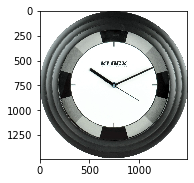

In [108]:
mislabeled_images(actual = 'HomeDecor&FestiveNeeds', predicted = 'Watches')

### 2-D visualizations

#### Features dimension reduction : KMeans

In [109]:
reduced_2d_train_features = kmeans_dimension_reduction(reduced_train_features, 50)

#### TSNE

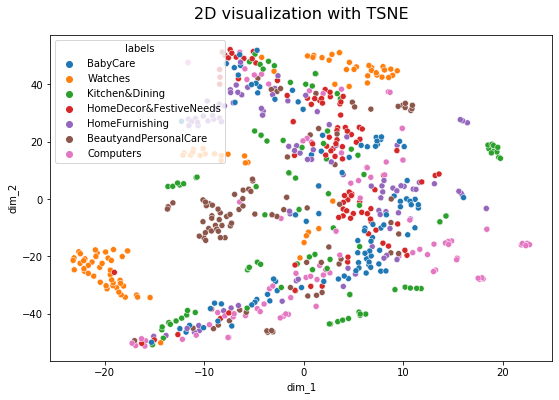

In [110]:
tsne_reduction(reduced_2d_train_features, 2, y_train)

#### PCA

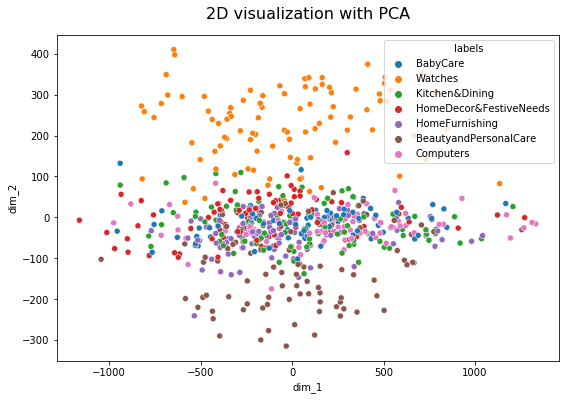

In [111]:
pca_reduction(reduced_2d_train_features, 2, y_train)

#### UMAP

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0, random_state=42, verbose=True)
Construct fuzzy simplicial set
Mon Jan 18 23:06:17 2021 Finding Nearest Neighbors
Mon Jan 18 23:06:17 2021 Finished Nearest Neighbor Search
Mon Jan 18 23:06:17 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jan 18 23:06:19 2021 Finished embedding


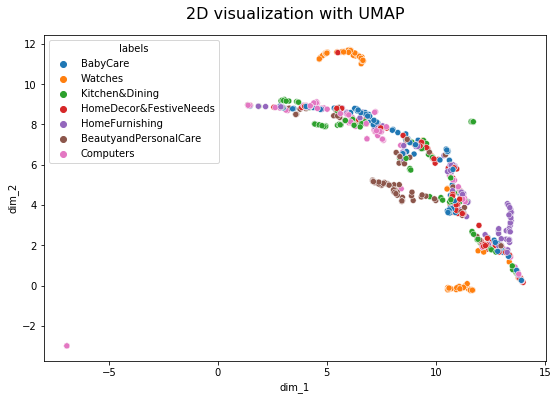

In [112]:
umap_reduction(reduced_2d_train_features, 2, y_train)

* Although there is **overlapping** among **categories** we can still distinguish **coherent groups of samples** belonging to the same **category**


* These 2-D **visualizations** suggest that the **extracted features** provide some **relevant** information to feed **estimators** and help find an accurate mapping

## Natural Language Processing

* As for with images, the key is to **extract features** from the product **descriptions** to feed **estimators**


* We will implement different **feature extraction** techniques:
    * Universal Sentence Encoder
    * Bag of Words
    * Tf-idf
    * LDA
  

### Preprocessing

* We will clean the texts in the corpus by applying various preprocessing steps
    * remove **digits**
    * remove **punctuation** signs
    * **lowercase** the letters for equalizing all words and before implementing stop words selection
    * **tokenize** ie transform a string into separated tokens (words)
    * remove all tokens (words) with **less than 3 letters** included
    * remove **stop words**
    * **lemmatize** or **stem**
    

#### Lemmatizer

* Lemmatizing consists of reducing a word to its most common form or **lemma** (eg. lemma is the lemmatized form of lemmas)

* It allows to keep **existing words** in the corpus **vocabulary**

In [113]:
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
import string
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')


def lemma_preprocess(corpus):
    
    corpus = corpus.copy()
    
    #Removing numbers 
    for digit in range(10):
        corpus = [text.replace(str(digit), ' ') for text in corpus]
        
        
    # Removing punctuation
    for sign in string.punctuation:
        corpus = [text.replace(sign, ' ') for text in corpus]
        
    ### Lowering letters 
    
    corpus = [text.lower() for text in corpus]
    
    
    # Tokenizing 

    lists_of_tokens = [word_tokenize(text) for text in corpus]
    
    
    ### Removing words with less than 3 letters
    
    lists_of_tokens = [[token for token in list_of_tokens if len(token) > 3] 
                      for list_of_tokens in lists_of_tokens]
    
    ### Remove 'stop words'
    
    cleaned_lists_of_tokens = [[token for token in list_of_tokens 
                            if token not in stopwords.words('english')] 
                                       for list_of_tokens 
                                  in lists_of_tokens]
    
    
    ###Lemmatize
    lemmatizer = WordNetLemmatizer()
    
    lists_of_lemmas = [[lemmatizer.lemmatize(token) for token in list_of_tokens] for list_of_tokens 
            in cleaned_lists_of_tokens]
    
    
    ### Convert list of strings to string
    new_corpus = [' '.join(list_of_lemmas) for list_of_lemmas in lists_of_lemmas]
    
    
    return new_corpus

[nltk_data] Downloading package wordnet to /home/marco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/marco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/marco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Stemmer

* **Stemming** consists of reducing a word to its radical form (eg. onlin for online)


* Thus it operates a **more important** dimension reduction but creates sometimes **non-existing words**

In [114]:
def stem_preprocess(corpus):
    
    corpus = corpus.copy()
    
    #Removing numbers 
    for digit in range(10):
        corpus = [text.replace(str(digit), ' ') for text in corpus]
        
        
    # Removing punctuation
    for sign in string.punctuation:
        corpus = [text.replace(sign, ' ') for text in corpus]
        
    ### Lowering letters 
    
    corpus = [text.lower() for text in corpus]
    
    
    # Tokenizing 

    lists_of_tokens = [word_tokenize(text) for text in corpus]
    
    
    ### Removing words with less than 3 letters
    
    lists_of_tokens = [[token for token in list_of_tokens if len(token) > 3] 
                      for list_of_tokens in lists_of_tokens]
    
    ### Remove 'stop words'
    
    cleaned_lists_of_tokens = [[token for token in list_of_tokens 
                            if token not in stopwords.words('english')] 
                                       for list_of_tokens 
                                  in lists_of_tokens]
    
    ###Stem
    stemmer = PorterStemmer()
    
    lists_of_stems = [[stemmer.stem(token) for token in list_of_tokens] for list_of_tokens 
in cleaned_lists_of_tokens]
    
    
   ### Convert list of strings to string
    new_corpus = [' '.join(list_of_stems) for list_of_stems in lists_of_stems]

    return new_corpus

#### Dimensionality

* We will compare the **number of unique words** generated by each **approach**

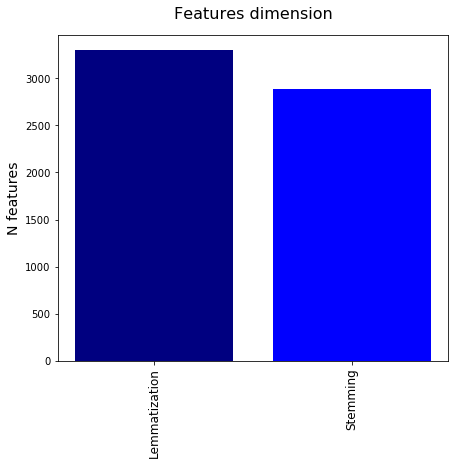

In [115]:
from sklearn.feature_extraction.text import CountVectorizer


def lemmatizing_stemming_dimensions():
    ### perfoming transformations
    lemmatized_corpus = lemma_preprocess(X_train['description'])
    stemmed_corpus = stem_preprocess(X_train['description'])


    ### get number of features (ie unique words among the corpus) with lemmatizer 
    vec = CountVectorizer()
    vec.fit(lemmatized_corpus)
    lemmatized_n_features = len(vec.get_feature_names())

    ### same with stemmer
    vec.fit(stemmed_corpus)
    stemmed_n_features = len(vec.get_feature_names())


    fig = plt.figure(figsize = (7,6))
    ax = fig.add_subplot(111)


    ax.bar(np.arange(0,2,1), height = [lemmatized_n_features, stemmed_n_features], 
        width = 0.8, color = ['navy', 'blue'])
    ax.set_title('Features dimension', fontsize = 16, pad = 16)
    ax.set_ylabel('N features', fontsize = 14)
    ax.set_xticks(np.arange(0,2,1))
    ax.set_xticklabels(['Lemmatization', 'Stemming'], fontsize = 12, rotation = 90)

    
lemmatizing_stemming_dimensions()

* **Lemmatization** creates ~ **3200** features
* **Stemming** creates ~ **2800** features
* The difference in terms of **dimensionality** is **not so important** 
* We will keep **lemmas** so we work with **real words**

In [116]:
train_corpus = lemma_preprocess(X_train['description'])
valid_corpus = lemma_preprocess(X_valid['description'])

#### Universal Sentence Encoder

* **Universal Sentence Encoder** is a text transformer that implements **pre-trained embedding layers**


* Basically it **represents each word** in a text as a **vector**

In [117]:
import tensorflow_hub as hub

def embed(corpus):

    module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
    
    ### load embedding pre-trained model
    model = hub.load(module_url)

    # Performs encoding and converts to array
    ### the model takes as input a sequence of texts
    output = np.array(model(corpus))
    
    return output

In [118]:
train_use_features, valid_use_features = embed(train_corpus), embed(valid_corpus)
train_use_features.shape

(671, 512)

##### Estimators

* As for the previous approach we will try widely used classifiers
    * knn
    * Support Vector Machines
    * Random Forest
    * Neural network classification layer
    * Dummy classifier for the baseline
    


* The goal is to reach the **best possible model**, ie the best **features** & the best **estimator**


* Also we will be able to **compare** directly the two **feature extraction** techniques, having trained the **same estimators** on features extracted by each approach

In [119]:
neural_network_accuracy, rf_accuracy, svc_accuracy, knn_accuracy, dummy_accuracy = get_estimators_scores(reduced_train_features, reduced_valid_features, y_train, y_valid)

Epoch 1/5
21/21 [==============================] - 0s 5ms/step - loss: 451.1453 - accuracy: 0.6870 - val_loss: 818.3337 - val_accuracy: 0.7798
Epoch 2/5
21/21 [==============================] - 0s 2ms/step - loss: 200.4242 - accuracy: 0.9240 - val_loss: 1022.9628 - val_accuracy: 0.8036
Epoch 3/5
21/21 [==============================] - 0s 2ms/step - loss: 36.2594 - accuracy: 0.9762 - val_loss: 998.9160 - val_accuracy: 0.8095
Epoch 4/5
21/21 [==============================] - 0s 2ms/step - loss: 1.4412 - accuracy: 0.9955 - val_loss: 963.8246 - val_accuracy: 0.8333
Epoch 5/5
21/21 [==============================] - 0s 2ms/step - loss: 0.0594 - accuracy: 0.9985 - val_loss: 962.8240 - val_accuracy: 0.8333


##### Ranking

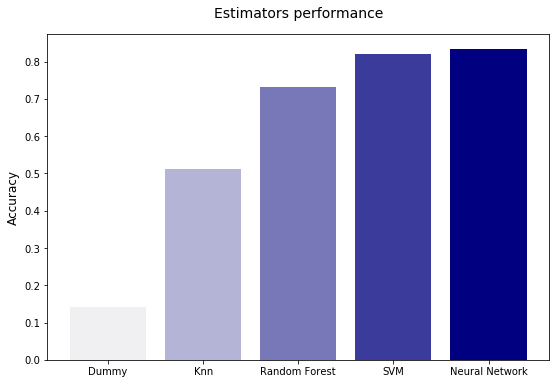

In [120]:
ranking([('Neural Network', neural_network_accuracy), 
        ('Random Forest', rf_accuracy), 
        ('SVM', svc_accuracy), 
        ('Knn', knn_accuracy), 
        ('Dummy', dummy_accuracy)])

* The performance of some **estimators** on accuracy is **strong**, nearly equal to their performance when trained on **Resnet-extracted features**


* The **NLP** approach seems **relevant** to predict **categories** as well

#### Bag of words

* **Bag of Words** represents each **text** as a **histogram** vector

* The histogram contains **occurrences** of each word of the **corpus** in the **text**

In [125]:
def bow(train_corpus, validation_corpus):
    
    vec = CountVectorizer()
    
    ### count vectorizer fits a sequence of texts (ie strings)
    ### and outputs for each text a vector as a histogram 
    ### with number of occurrences of each word of the corpus
    
    train_features = vec.fit_transform(train_corpus).toarray()
    valid_features = vec.transform(validation_corpus).toarray()
    names = vec.get_feature_names()
    
    return train_features, valid_features, names


In [126]:
bow_train_features, bow_valid_features, names = bow(train_corpus,valid_corpus)
bow_train_features.shape

(671, 3296)

In [127]:
### We will divide each vector by the number of words in the sentence 
###to get frequencies of each word instead of occurrences
### this allows to control for the length of the texts which is not equal accross texts

### divide each text-histogram (line in the 2-D array) by its number of words
bow_train_features = [vector/sum(vector) for vector in bow_train_features]
bow_train_features = np.array(bow_train_features)

bow_valid_features = [vector/sum(vector) for vector in bow_valid_features]
bow_valid_features = np.array(bow_valid_features)

##### Estimators

* As for the previous approach we will try widely used classifiers
    * knn
    * Support Vector Machines
    * Random Forest
    * Neural network classification layer
    * Dummy classifier for the baseline
    


* The goal is to reach the **best possible model**, ie the best **features** & the best **estimator**


* Also we will be able to **compare** directly the two **feature extraction** techniques, having trained the **same estimators** on features extracted by each approach

In [128]:
neural_network_accuracy, rf_accuracy, svc_accuracy, knn_accuracy, dummy_accuracy = get_estimators_scores(bow_train_features, bow_valid_features, y_train, y_valid)

Epoch 1/5
21/21 [==============================] - 0s 6ms/step - loss: 1.9554 - accuracy: 0.1282 - val_loss: 1.9296 - val_accuracy: 0.1429
Epoch 2/5
21/21 [==============================] - 0s 3ms/step - loss: 1.9272 - accuracy: 0.2727 - val_loss: 1.8882 - val_accuracy: 0.3452
Epoch 3/5
21/21 [==============================] - 0s 3ms/step - loss: 1.8910 - accuracy: 0.3890 - val_loss: 1.8595 - val_accuracy: 0.3810
Epoch 4/5
21/21 [==============================] - 0s 3ms/step - loss: 1.8640 - accuracy: 0.4724 - val_loss: 1.8338 - val_accuracy: 0.5357
Epoch 5/5
21/21 [==============================] - 0s 3ms/step - loss: 1.8407 - accuracy: 0.5112 - val_loss: 1.8121 - val_accuracy: 0.5774


##### Ranking

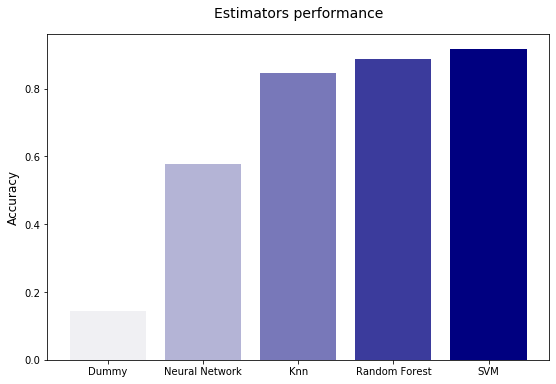

In [129]:
ranking([('Neural Network', neural_network_accuracy), 
        ('Random Forest', rf_accuracy), 
        ('SVM', svc_accuracy), 
        ('Knn', knn_accuracy), 
        ('Dummy', dummy_accuracy)])

* **BOW** extracts very **relevant** features
* **SVM** performance is nearly ~ **0.9** in accuracy

Text(0.5, 1.0, 'BOW : Random Forest feature importances')

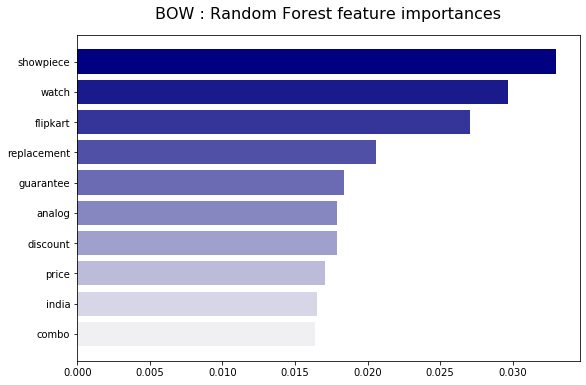

In [130]:

### we will implement Random Forest feature importances attribute to get insights on the words 
### with most relevance in the corpus

rf = RandomForestClassifier()
rf.fit(bow_train_features, y_train)


fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(111)

labels, importances = zip(*sorted(zip(names, rf.feature_importances_), 
                        key = lambda k : k[1]))

palette = sns.light_palette("navy", n_colors = 10)


ax.barh(np.arange(0,10,1), width = importances[-10:], color = palette)
ax.set_yticks(np.arange(0,10,1))
ax.set_yticklabels(labels[-10:])
ax.set_title('BOW : Random Forest feature importances', fontsize = 16, pad = 16)

#### TF-idf

* Term-frequency inverse-document frequency is a **transformer** that takes into account the **frequency of a word accross texts**


* The general idea is to give more **importance** to words that are **specific** to texts 

In [131]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tf_idf(train_corpus, validation_corpus):

    vec = TfidfVectorizer()
    
    train_features = vec.fit_transform(train_corpus).toarray()
    valid_features = vec.transform(validation_corpus).toarray()
    names = vec.get_feature_names()
    
    return train_features, valid_features, names

    return train_features, valid_features, names

In [132]:
tf_idf_train_features, tf_idf_valid_features, names = tf_idf(train_corpus, valid_corpus)

tf_idf_train_features.shape

(671, 3296)

##### Estimators

* As for the previous approach we will try widely used classifiers
    * knn
    * Support Vector Machines
    * Random Forest
    * Neural network classification layer
    * Dummy classifier for the baseline
    


* The goal is to reach the **best possible model**, ie the best **features** & the best **estimator**


* Also we will be able to **compare** directly the two **feature extraction** techniques, having trained the **same estimators** on features extracted by each approach

In [133]:
neural_network_accuracy, rf_accuracy, svc_accuracy, knn_accuracy, dummy_accuracy = get_estimators_scores(tf_idf_train_features, tf_idf_valid_features, y_train, y_valid)

Epoch 1/5
21/21 [==============================] - 0s 5ms/step - loss: 1.8652 - accuracy: 0.3398 - val_loss: 1.6704 - val_accuracy: 0.6369
Epoch 2/5
21/21 [==============================] - 0s 3ms/step - loss: 1.5493 - accuracy: 0.8033 - val_loss: 1.3670 - val_accuracy: 0.8393
Epoch 3/5
21/21 [==============================] - 0s 3ms/step - loss: 1.2990 - accuracy: 0.9061 - val_loss: 1.1842 - val_accuracy: 0.8452
Epoch 4/5
21/21 [==============================] - 0s 3ms/step - loss: 1.1403 - accuracy: 0.9195 - val_loss: 1.0656 - val_accuracy: 0.8929
Epoch 5/5
21/21 [==============================] - 0s 3ms/step - loss: 1.0319 - accuracy: 0.9270 - val_loss: 0.9841 - val_accuracy: 0.8929


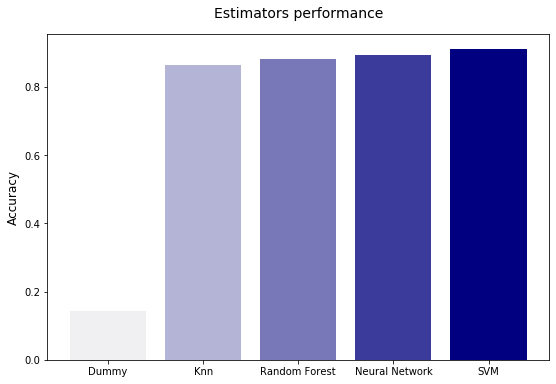

In [134]:
ranking([('Neural Network', neural_network_accuracy), 
        ('Random Forest', rf_accuracy), 
        ('SVM', svc_accuracy), 
        ('Knn', knn_accuracy), 
        ('Dummy', dummy_accuracy)])

* The performance of **estimators** trained on features extracted implementing **TF-IDF** is **strong** and pretty much the same than when trained on **BOW**

Text(0.5, 1.0, 'TF-IDF : Random Forest feature importances')

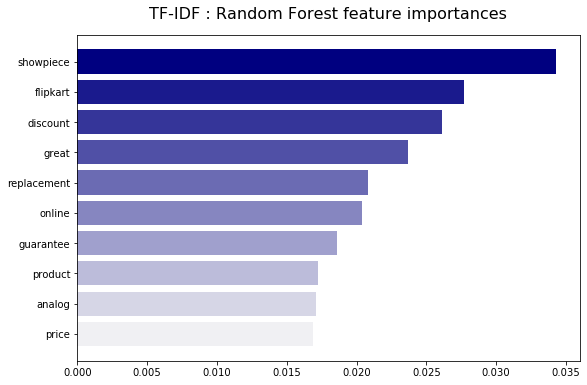

In [135]:
fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(111)

### we will implement Random Forest feature importances attribute to get insights on the words 
### with most relevance in the corpus

rf = RandomForestClassifier()
rf.fit(tf_idf_train_features, y_train)

labels, importances = zip(*sorted(zip(names, rf.feature_importances_), 
                        key = lambda k : k[1]))

palette = sns.light_palette("navy", n_colors = 10)


ax.barh(np.arange(0,10,1), width = importances[-10:], color = palette)
ax.set_yticks(np.arange(0,10,1))
ax.set_yticklabels(labels[-10:])
ax.set_title('TF-IDF : Random Forest feature importances', fontsize = 16, pad = 16)

* As for the **estimators' performance**, the **words** that generated most **splits** when fitting **RandomForest** are pretty much the **same** when extracting features with **BOW** or with **Tf-idf**

#### LDA

* **LDA** is a **probabilistic** feature extraction method


* It generates semantic **topics** from the **corpus** by taking into account the **covariance** of **words occurrences** in each text

In [136]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

def getting_lda_features(train_corpus, test_corpus):
    
    ### LDA needs a BOW input 
    vec = CountVectorizer()
    
    train_bow = vec.fit_transform(train_corpus)
    test_bow = vec.transform(test_corpus)
    
    ### We will look to define 7 topics as the number of classes we are trying to predict
    lda = LDA(n_components=7, random_state = 42)
    
    train_lda_features = lda.fit_transform(train_bow)
    test_lda_features = lda.transform(test_bow)
    
    return train_lda_features, test_lda_features

In [137]:
train_lda_features, valid_lda_features = getting_lda_features(train_corpus, valid_corpus)

##### Estimators

* As for the previous approach we will try widely used classifiers
    * knn
    * Support Vector Machines
    * Random Forest
    * Neural network classification layer
    * Dummy classifier for the baseline
    


* The goal is to reach the **best possible model**, ie the best **features** & the best **estimator**


* Also we will be able to **compare** directly the two **feature extraction** techniques, having trained the **same estimators** on features extracted by each approach

In [138]:
neural_network_accuracy, rf_accuracy, svc_accuracy, knn_accuracy, dummy_accuracy = get_estimators_scores(train_lda_features, valid_lda_features, y_train, y_valid)

Epoch 1/5
21/21 [==============================] - 0s 4ms/step - loss: 1.9265 - accuracy: 0.1863 - val_loss: 1.8126 - val_accuracy: 0.2619
Epoch 2/5
21/21 [==============================] - 0s 2ms/step - loss: 1.7619 - accuracy: 0.3189 - val_loss: 1.6939 - val_accuracy: 0.2619
Epoch 3/5
21/21 [==============================] - 0s 2ms/step - loss: 1.6978 - accuracy: 0.3577 - val_loss: 1.6650 - val_accuracy: 0.3214
Epoch 4/5
21/21 [==============================] - 0s 2ms/step - loss: 1.6817 - accuracy: 0.3696 - val_loss: 1.6493 - val_accuracy: 0.3274
Epoch 5/5
21/21 [==============================] - 0s 2ms/step - loss: 1.6711 - accuracy: 0.3815 - val_loss: 1.6414 - val_accuracy: 0.3393


##### Ranking

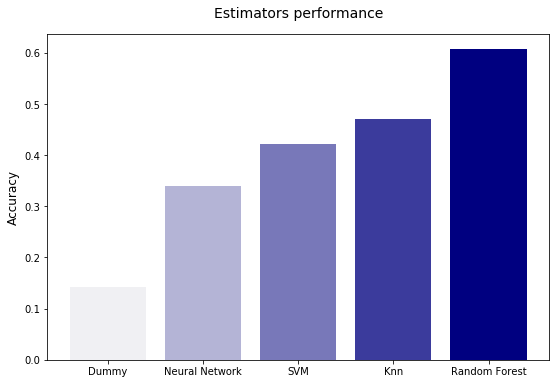

In [139]:
ranking([('Neural Network', neural_network_accuracy), 
        ('Random Forest', rf_accuracy), 
        ('SVM', svc_accuracy), 
        ('Knn', knn_accuracy), 
        ('Dummy', dummy_accuracy)])

* **Overall performance** is **weaker** with LDA approach

#### Best NLP approach : BOW

* The most **simple** feature extraction, ie **Bag of Words**, works the **best** here


* Some estimators such as SVM achieved a performance approx. ~ 0.9 in accuracy, which outperforms even the **computer vision** approach


* The **frequency** of some **specific terms** in the **corpus** seem to be enough to enable the **estimators** to fit a good mapping between **features** and **categories**

* Thus this static approach works well

##### Confusion Matrix

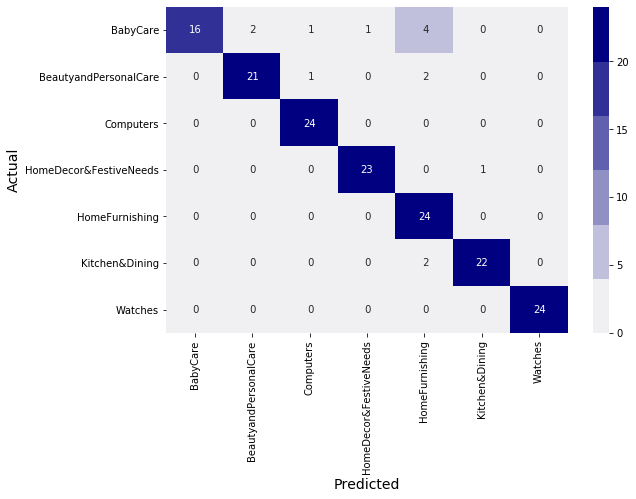

In [140]:
svc = SVC(random_state = 42)

svc.fit(bow_train_features, y_train)
svc_bow_pred = svc.predict(bow_valid_features)

conf_matrix(y_valid, svc_bow_pred)

##### 2-D visualization

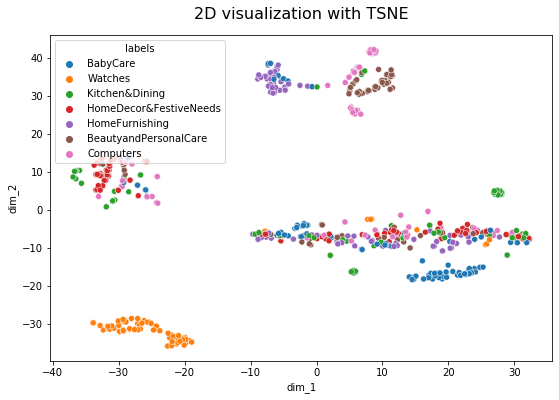

In [141]:
reduced_bow_features = kmeans_dimension_reduction(bow_train_features, 50)

tsne_reduction(reduced_bow_features, 2, y_train)

* Although there is **overlapping**, we can still identify **groups of samples** belonging to the same **category** in the **feature space**


* The **watches** for example seem **very well separated** from other **categories**

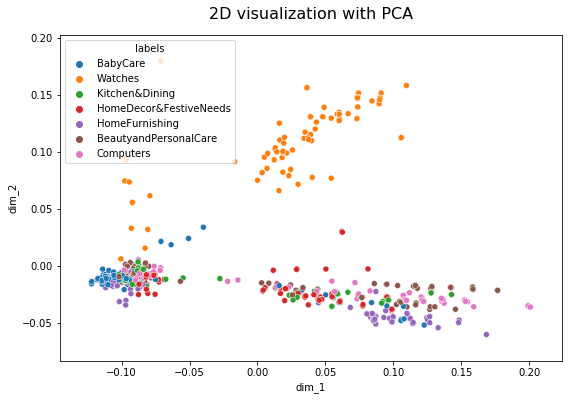

In [142]:
pca_reduction(bow_train_features,2,y_train)

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0, random_state=42, verbose=True)
Construct fuzzy simplicial set
Mon Jan 18 23:08:20 2021 Finding Nearest Neighbors
Mon Jan 18 23:08:20 2021 Finished Nearest Neighbor Search
Mon Jan 18 23:08:20 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jan 18 23:08:21 2021 Finished embedding


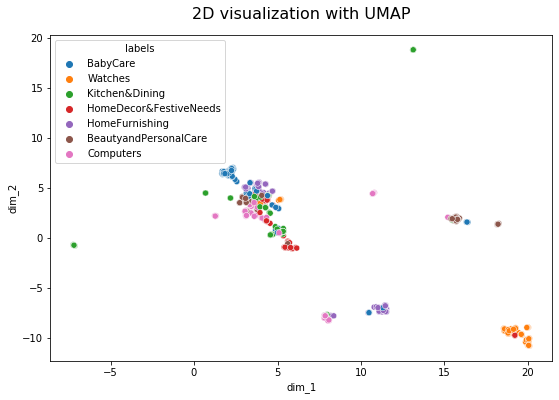

In [143]:
umap_reduction(bow_train_features, 2, y_train)

## Computer vision + NLP

* We will now reunite both best CV & NLP approaches into a single approach


* Basically we will **concatenate** **Resnet & BOW features** then train the estimators 

### Defining features

In [153]:
train_features = np.column_stack([reduced_train_features, bow_train_features])
valid_features = np.column_stack([reduced_valid_features, bow_valid_features])

### Estimators

In [154]:
neural_network_accuracy, rf_accuracy, svc_accuracy, knn_accuracy, dummy_accuracy = get_estimators_scores(train_features, valid_features, y_train, y_valid)

Epoch 1/5
21/21 [==============================] - 0s 5ms/step - loss: 438.9380 - accuracy: 0.6900 - val_loss: 769.8315 - val_accuracy: 0.7857
Epoch 2/5
21/21 [==============================] - 0s 3ms/step - loss: 183.6633 - accuracy: 0.9151 - val_loss: 1029.1971 - val_accuracy: 0.8393
Epoch 3/5
21/21 [==============================] - 0s 3ms/step - loss: 62.5518 - accuracy: 0.9598 - val_loss: 1152.5408 - val_accuracy: 0.8274
Epoch 4/5
21/21 [==============================] - 0s 3ms/step - loss: 8.4639 - accuracy: 0.9896 - val_loss: 1117.9058 - val_accuracy: 0.8333
Epoch 5/5
21/21 [==============================] - 0s 3ms/step - loss: 2.6527 - accuracy: 0.9955 - val_loss: 1104.2898 - val_accuracy: 0.8452


### Ranking

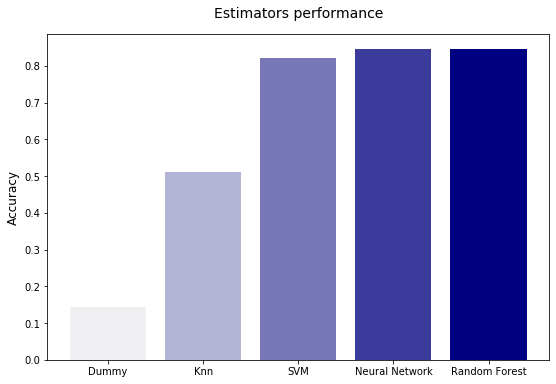

In [155]:
ranking([('Neural Network', neural_network_accuracy), 
        ('Random Forest', rf_accuracy), 
        ('SVM', svc_accuracy), 
        ('Knn', knn_accuracy), 
        ('Dummy', dummy_accuracy)])

* The overall performance with **both CV and NLP features** is likely an **average** of the estimators's performance when fitted on **each subset of features** separately   



* **BOW** is the **best approach** so far to predict product **categories**



* We will now build the whole **Pipeline**, **train** it on all the train data and conclude on the **generalization** of the model performance by **predicting the samples** of the test dataset and **evaluate them on accuracy score**



* The **Pipeline** contains three **steps**:
    * String **preprocessing** & **lemmatization**
    * **BOW** features extraction
    * **Support Vector Machines**

## Model generalization

In [159]:
from custom_transformers import String_preprocessor, Extracting_bow_features
from sklearn.pipeline import Pipeline


model = Pipeline([('preprocessor', String_preprocessor()), 
                 ('bow', Extracting_bow_features()),
                 ('SVC', SVC(random_state = 42))])

model.fit(X_train_['description'], y_train_)

y_pred = model.predict(X_test['description'])

### evaluate
test_accuracy = accuracy_score(y_test, y_pred)

print('Accuracy score on the test set is ' + str(test_accuracy.round(decimals = 2)))

Accuracy score on the test set is 0.93


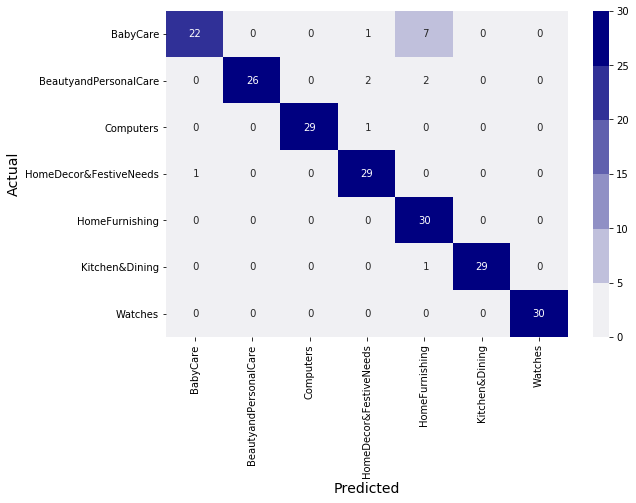

In [160]:
conf_matrix(y_test, y_pred)

# Conclusion

* The **model generalizes very well** ie its **performance** on **test** set on **accuracy** is **strong** and more or less **equal** than on the **validation** set


* The **model performance** is **strong** and its **deployment** would surely bring **value** to the **platform**


* Further research shall try to **optimize** the **feature extraction methods** (eg. train Deep learning models parameters) &  the estimators' **hyperparameters**